# GRU

# Preprocessing

In [1]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import io
import re
import string
import tqdm

physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0],True)

2022-10-31 23:29:17.539178: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-31 23:29:17.539194: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-31 23:29:21.149749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 23:29:21.150238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-31 23:29:21.150527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

In [2]:
%load_ext tensorboard
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv("./data/text_emotion.csv",encoding='utf8')

Getting embeddings using Word2Vec. Word2vec has 2 algorithms, 
1. Continuous Bag of words
    - word is predicted from context "__ my name is Kevin"
2. Skip Gram
    - context is predicted from target "Hi __ __ __ __"

In [4]:
len(df)

40000

## Data Cleaning
1. Getting rid of the punctuations marks from dataset
2. converting all content to lowercase

In [5]:
cleaned_df = df.copy()

exclude = set(string.punctuation)
regex = re.compile('[%s]' % re.escape(string.punctuation))
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: regex.sub("",sentence))
cleaned_df['content'] = cleaned_df['content'].str.lower()

x_ds = tf.data.Dataset.from_tensor_slices(cleaned_df['content'])
y_ds = tf.data.Dataset.from_tensor_slices(cleaned_df['sentiment'])

ds = tf.data.Dataset.zip((x_ds,y_ds))

The cleaned data looks like this. 
now we want to find the number of unique words to rationalise the size of a embedding vector
We also want to find the maximum number of words in a sentence

In [6]:
max_sentence_len = cleaned_df['content'].str.len().max()
vocab_size = cleaned_df['content'].apply(lambda content: len(content.split())).sum()

print("max sentence length of content is {}".format(max_sentence_len))
print("total number of words/vocab size of content is {}".format(vocab_size))

max sentence length of content is 151
total number of words/vocab size of content is 522917


So our input vocab size must be at least 151 to fully take in 1 sentence <br>
Since it is computationally heavy to have a vector of 522948 in size. <br>
We will use a vector of only 256, meaning that in the bag of words algorithm, the words will only take 255 other context words as input

Combine the steps to one function

In [7]:
def generate_training_data(sequences, window_size,num_ns,vocab_size,seed):
    
    # each training sentence is appended to these list
    targets,contexts,labels = [],[],[]
    
    # sampling table for vocab_size tokens
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)
    
    # iterate over all sentences in dataset
    for sequence in tqdm.tqdm(sequences):
       

        # generating positive skip-gram pairs for a sequence
        positive_skip_grams,_ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size = vocab_size,
            sampling_table=sampling_table,
            window_size=window_size, # TODO: change window size
            negative_samples=0
        )
        
        # produce negative samples and create training samples (x_train,labels)
        for target_word, context_word in positive_skip_grams:
    
    
            # expand context word to frmo dim shape (1,0) to (1,1)
            context_class = tf.expand_dims(
                tf.constant([context_word],dtype='int64'),1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class, # to tell the which sample is positive
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size, #TODO: may need to change to just the negative samples of the sentence itself instead of the entire vocab
                seed=seed,
                name='negative_sampling')
    
    
            # building the context and label vectors for a target word
            context = tf.concat([tf.squeeze(context_class,1),negative_sampling_candidates],0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")
    
    
            # append each element from the training ex to global lists
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)
    
    
    return targets, contexts, labels 
            
            

## Preparing training data for word2vec

In [8]:
# size of one sentence is 151 but we just use 256
sequence_length = 256

vectorize_layer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

2022-10-31 23:29:21.451684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## tokenise the words in content according to their indices

In [9]:
# TODO change to smaller batch for better results
batch_size = 1024

In [10]:
# creating a dataset of all sentences
text_ds = tf.data.Dataset.from_tensor_slices(cleaned_df['content'])
vectorize_layer.adapt(text_ds.batch(batch_size))

In [11]:
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'i', 'to', 'the', 'a', 'my', 'and', 'you', 'it', 'is', 'in', 'for', 'of', 'im', 'on', 'me', 'have', 'so', 'that']


In [12]:
# Vectorize the data in text_ds.
# prefetch does fetching of data and training at the same time using multiple thread
# improving performance
text_vector_ds = text_ds.batch(batch_size).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

As you can see we have successfully vectorised our sentences/sequences

In [13]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

40000


## Over here we are using unsupervised learning to predict context from targets. While doing so, we are also training the weights on the embeddings. We can increase window size so that the embeddings learn more contextutal knowledge with respect to the words around them

In [14]:
# note higher window size is more computationally expensive
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [01:04<00:00, 622.31it/s]




targets.shape: (384799,)
contexts.shape: (384799, 5)
labels.shape: (384799, 5)


Configuring training sets for Word2Vec model

In [15]:
BATCH_SIZE = batch_size
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [16]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [17]:
num_ns=4
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = layers.Embedding(vocab_size,
              embedding_dim,
              input_length=1,
              name="w2v_embedding")
        self.context_embedding = layers.Embedding(vocab_size,
               embedding_dim,
               input_length=num_ns+1)

    def call(self, pair):
        target, context = pair
        # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
        # context: (batch, context)
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
        # target: (batch,)
        word_emb = self.target_embedding(target)
        # word_emb: (batch, embed)
        context_emb = self.context_embedding(context)
        # context_emb: (batch, context, embed)
        dots = tf.einsum('be,bce->bc', word_emb, context_emb)
        # dots: (batch, context)
        return dots

In [18]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [19]:
# embedding size for word2vec lets try 256 since it is more than a sentence
embedding_dim = 256
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
# call back to log training stats for TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [20]:
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
 32/375 [=>............................] - ETA: 12:07 - loss: 1.6092 - accuracy: 0.2086

KeyboardInterrupt: 

Embedding lookup and analysis

In [ ]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [ ]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

# GRU model

In [ ]:
def read_tsv(path):
    result = []
    file = open(path,'r',encoding='utf-8')
    while (True):
        line = file.readline()
        if not line:
            break
        result.append(line.split())
        
    file.close()
    return np.array(result)

In [ ]:
vectors = read_tsv('./data/vectors.tsv')

In [ ]:
def read_meta(path):
    result = []
    file = open(path,'r',encoding='utf-8')
    while (True):
        line = file.readline()
        if not line:
            break
        result+=line.split()
        
    file.close()
    return np.array(result)

In [ ]:
classes = read_meta('./data/metadata.tsv')

## Preprocessing for GRU: one hot encoding the labels

In [ ]:
print('Unique labels:')
for i, label in enumerate(cleaned_df['sentiment'].unique()):
    print('{}) {}'.format(i,label)) 

In [ ]:
cleaned_df['sentiment'].nunique()

# Build a one hot vector each of size 13 for sentiments as labels

### build a map for the labels to the indices

In [ ]:
# map labels -> indices
sentiment_labels = cleaned_df['sentiment'].unique().copy()

# index key -> class
label_map = {}

#class -> index key
inverse_label_map = {}
for i, label in enumerate(sentiment_labels):
    label_map[i] = label 
    inverse_label_map[label] = i

In [ ]:
# get all keys
indices = []
for key,value in label_map.items():
    indices.append(key)

In [ ]:
indices

### Generates one-hot vector for labels

In [ ]:
# maps the word to the one hot vector
depth = len(indices)
one_hot_encoding = tf.one_hot(indices,depth)

In [ ]:
one_hot_encoding

Map the one hot encodings to the labels in the dataframe

In [ ]:
# instantiate the preprocessed dataframe to feed into the model
cleaned_df['label'] = cleaned_df['sentiment'].apply(lambda n: one_hot_encoding[inverse_label_map[n]])

Map the embeddings to each word of the sentence

In [ ]:
# make an inverse index of the classes name -> index
inverse_vector_index = {}
for index,word in enumerate(classes):
    inverse_vector_index[word] = index

In [ ]:
inverse_vector_index.keys()

In [ ]:
cleaned_df['continuous_vector'] = cleaned_df['content'].apply(lambda sentence: [inverse_vector_index[word] for word in sentence.split()])

In [ ]:
cleaned_df

In [ ]:
ds = tf.data.Dataset.from_tensor_slices(zip(cleaned_df['content'],clean)

In [ ]:
#
preprocessed_df['vectors'] = vector_df

In [ ]:
preprocessed_df

In [ ]:
# using first 70* of dataset as training data
vector_df[:]

# Model of GRU

In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=(None, 256)))
model.add(layers.GRU(256, return_sequences=True, activation="tanh"))
model.add(layers.GRU(256, activation='tanh'))
model.add(layers.Dense(10))
model.add(layers.Softmax())

In [ ]:
model.fit(x_train, y_train, batch_size=64, epochs=10, verbose=2)

## Brief description of method used

Tokenisation -> turning each word into a number, this is ok but the high numbers on a word is not so good for machine learning
i.e. (1, aardvark), (123,you), the 123 not so good for machine learning

A better way is to convert words into one hot vectors. in one hot vectors, each word is a *unit* vector in its own dimensionaxis and is at 90 degree from all other vectors
i.e. aardvark -> [1,0,0,0,0,... n ], where n is the number of words in the training dataset, and you - >[0,0,0,...1,...] -> bad thing about this is that the dimension of a one-hot vector = number of distinct words in the dataset/corpus, it could be very large.
drawback of one hot encoding? the words might not be perfectly a unit vector and might have relations with other words. A even better way is to represent the words as a *continuous* vector in N-dimentional space

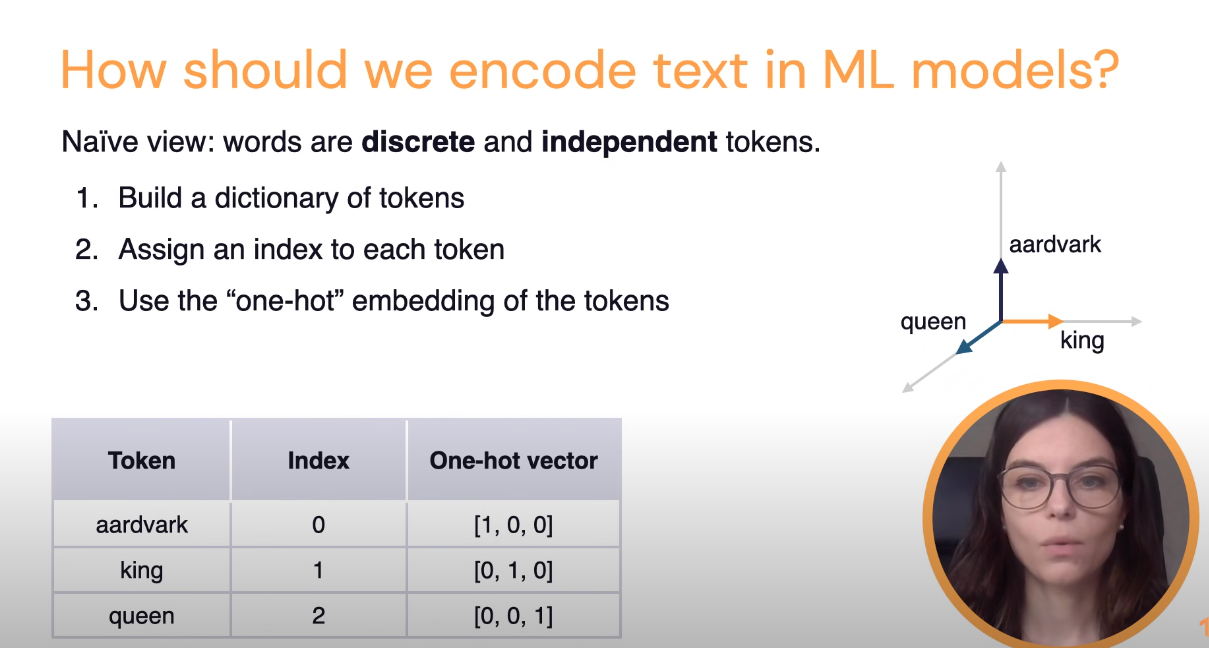

Continous vector in N-dimensional space. vector has more realistic values (also called continuous embeddings)

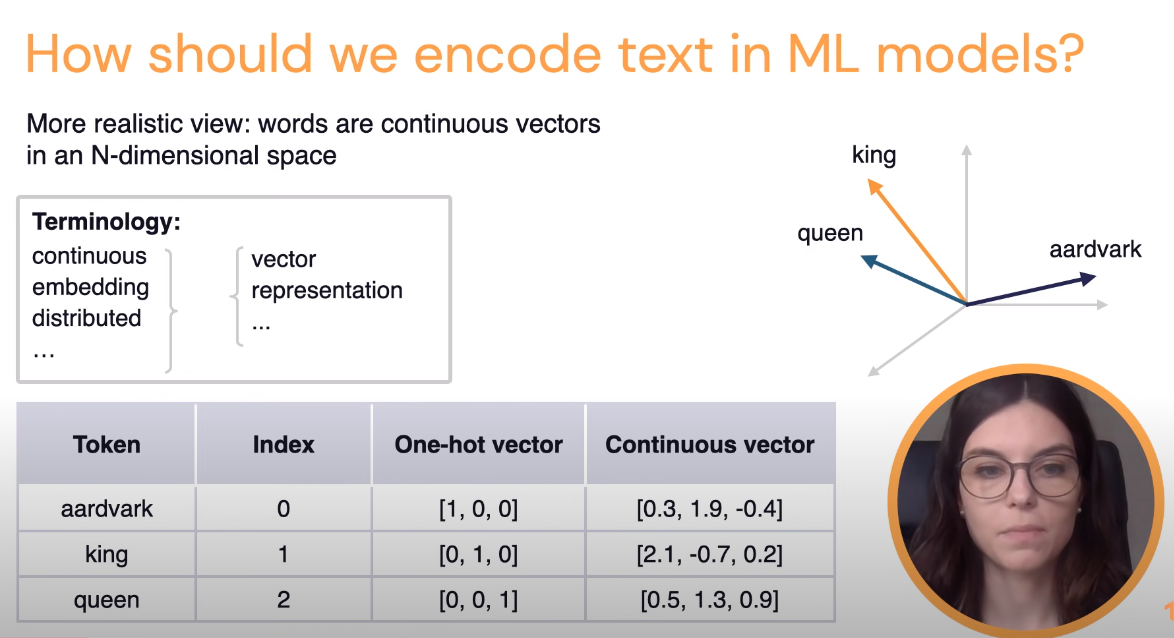

How does vectors work in telling how similar/different the token is? we use relative vector distance
i.e.
case 1: in the 3 dimensional graph of the gender dimension, the vectors representing "man" and "woman" are far apart, this shows that the tokens are very different.
However in the 3 dimension of part-of-speech, they are quite close together because they are all "nouns"
We aim for the continuous embeddings to display such qualities.

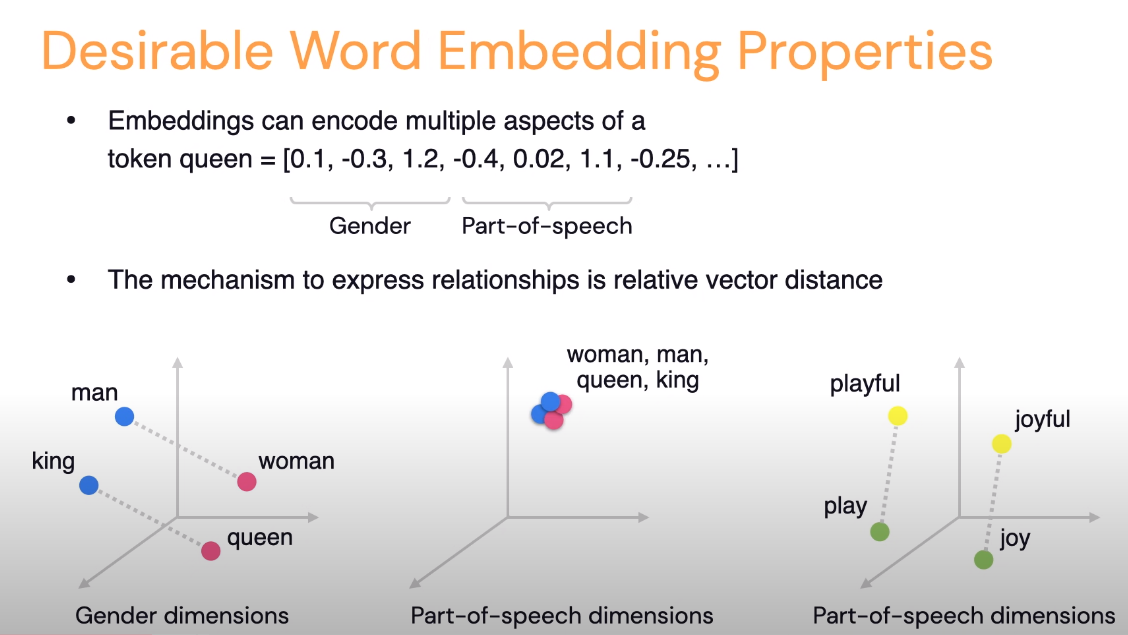

Notes:
1. Word2Vec

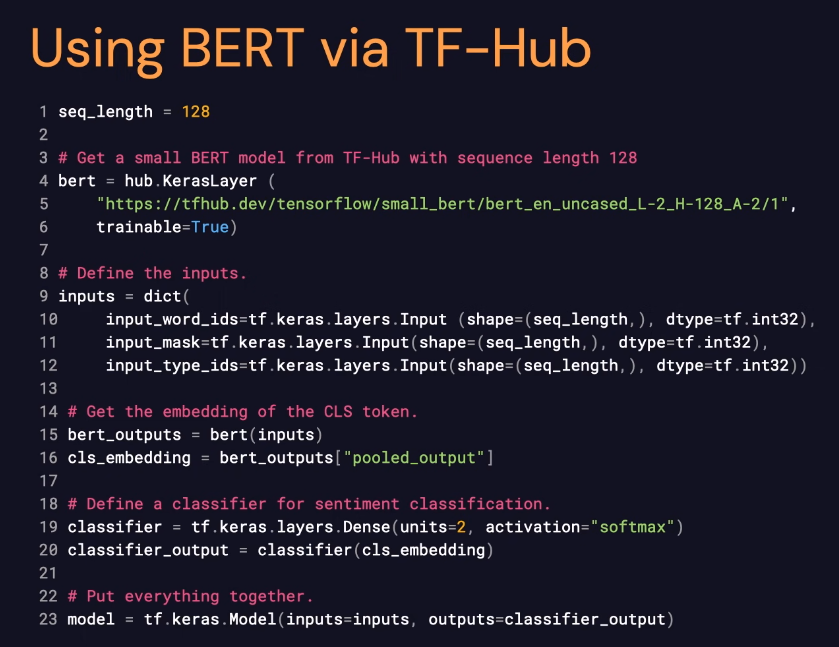

A problem with Word2Vec embeddings is that in the embedding a single word is mapped to all contexts, whereas in reality that is not the case
i.e. river bank vs UOB bank, the banks referred here have totally different meanings, but in the model it is mapped to the same vector

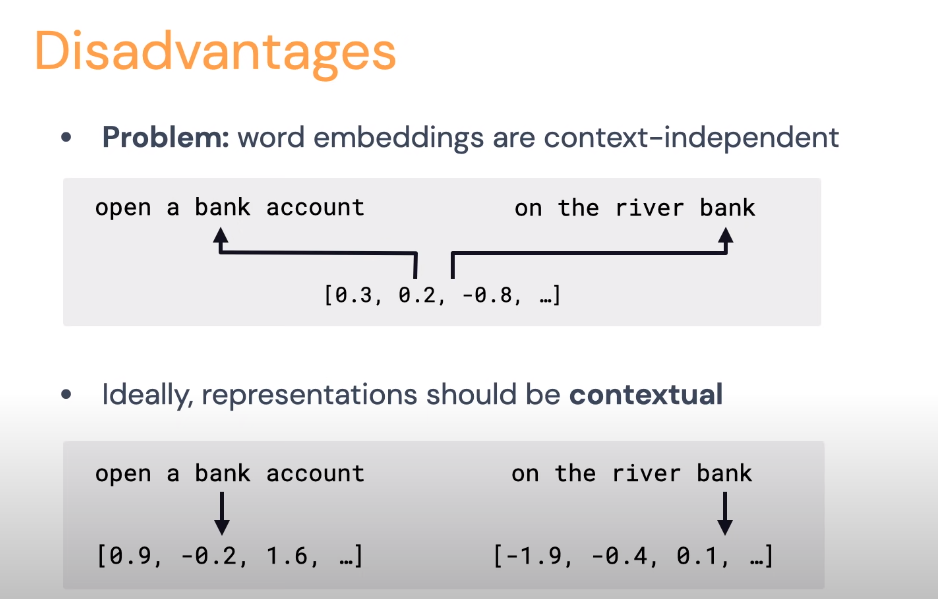

In RNN, we can start with a Non-contextual embeddings X_i (word2Vec) which cna be looked up in a table.
RNN takes input from previous hidden states in the sentence, thus the current embedding will be trained on the "context" on the previous words. The result from an  RNN during training is a new corpus with new continous vectors containing contextual meaning

Disadvantages, 
RNN is quite slow and cannot be parallised is because the current word requires all previous sequences
RNN has a vanishing gradient problem where words further away from the current predicited word will be considered less in thhe context
RNN is processes words unidirectionally, left to right, which is very unlike humans
i.e. "on the river bank"
if rnn processed this it will take the relevant context of the river into account for prediction of bank
however if this sentence is used "on the bank of the river" the relevant ccontext of "river" which was used for bank came after "bank". making predictions less accurate (model might think it means the financial institution bank) due to the absence of the "river" context
Transformers solve this problem by teaching the model to take context both from the left hand side and the right hand side.

# LSTM implementation

# Experiments and results